This notebook tests a small set of experiments. It investigates the circuits from QVOL 5 qubits 
with depth from 1 to 10.

The goal is to have the lookahead outperform the rest of the pass managers. 

In [1]:
from qiskit.transpiler.passes.routing.sabre_swap       import SabreSwap   as SabreSwap_v045
from qiskit.transpiler.passes.layout.sabre_layout      import SabreLayout as SabreLayout_v045
from qiskit.transpiler.passes.routing.sabre_swap_v020  import SabreSwap as SabreSwap_v020
from qiskit.transpiler.passes.layout.sabre_layout_v020 import SabreLayout as SabreLayout_v020
from qiskit.transpiler.passes.routing.sabre_swap_v020_lookahead import SabreSwap as SabreSwap_v020_lookahead


from ulti.circuits import get_circuit_list, sort_circuits_by_depth
from ulti.coupling_maps import file_to_coupling_map
from ulti.pass_managers import build_pm
import time

Setting up circuits and transpiler passes

In [2]:
qc_name = "size5_depth_1-10"
cp_name = "hex_7"
cm = file_to_coupling_map(f'coupling_maps/{cp_name}.txt')
seed = 42

# variables to change
lookahead = 5
fast_layout = False

# pass manager for Sabre v0.45
rp_v045 = SabreSwap_v045
lp_v045 = SabreLayout_v045
pm_v045 = build_pm(rp_v045, lp_v045, cm, seed=seed, fast_layout=fast_layout)

# pass manager for Sabre v0.20
rp_v020 = SabreSwap_v020
lp_v020 = SabreLayout_v020
pm_v020 = build_pm(rp_v020, lp_v020, cm, seed=seed, fast_layout=fast_layout)

# pass manager for Sabre v0.20 with lookahead
rp_v020_lookahead = SabreSwap_v020_lookahead
lp_v020_lookahead = SabreLayout_v020
pm_v020_lookahead = build_pm(rp_v020_lookahead, lp_v020_lookahead, cm, seed=seed, 
                             lookahead=lookahead, fast_layout=fast_layout)

qc_list = get_circuit_list([f'circuits/{qc_name}/'])
qc_list = sort_circuits_by_depth(qc_list)

In [3]:
# confirm the circuit depth is expected
for i, qc in enumerate(qc_list):
    print(f"Depth of the circuit {i+1}:", qc.decompose().depth())

Depth of the circuit 1: 1
Depth of the circuit 2: 2
Depth of the circuit 3: 3
Depth of the circuit 4: 4
Depth of the circuit 5: 5
Depth of the circuit 6: 6
Depth of the circuit 7: 7
Depth of the circuit 8: 8
Depth of the circuit 9: 9


In [4]:
# draw each of the circuits
for i, qc in enumerate(qc_list):
    print(f"Circuit {i+1}:\n")
    print(qc.decompose().draw(output='text'))
    print("\n")
    print("-"*100)

Circuit 1:

                   ┌────────────┐
q_0: ──────────────┤0           ├
                   │            │
q_1: ──────────────┤            ├
     ┌────────────┐│            │
q_2: ┤1           ├┤  Unitary_1 ├
     │  Unitary_0 ││            │
q_3: ┤0           ├┤            ├
     └────────────┘│            │
q_4: ──────────────┤1           ├
                   └────────────┘


----------------------------------------------------------------------------------------------------
Circuit 2:

                   ┌────────────┐┌────────────┐
q_0: ──────────────┤1           ├┤0           ├
     ┌────────────┐│            ││  Unitary_3 │
q_1: ┤0           ├┤            ├┤1           ├
     │  Unitary_1 ││  Unitary_0 │├────────────┤
q_2: ┤1           ├┤            ├┤0           ├
     └────────────┘│            ││            │
q_3: ──────────────┤0           ├┤  Unitary_2 ├
                   └────────────┘│            │
q_4: ────────────────────────────┤1           ├
                   

In [5]:
depths_45 = []
depths_20 = []
depths_20_look = []

# Loop through the circuits and run them through the pass managers
for i, qc in enumerate(qc_list):
    qc = qc.decompose()


    # Transpile using v0.45
    start_45 = time.time()
    qc_tr_45 = pm_v045.run(qc)
    end_45 = time.time()
    duration_45 = end_45 - start_45
    depth_45 = qc_tr_45.decompose(["swap"]).depth()
    depths_45.append(depth_45)

    # Transpile using v0.20
    start_20 = time.time()
    qc_tr_20 = pm_v020.run(qc)
    end_20 = time.time()
    duration_20 = end_20 - start_20
    depth_20 = qc_tr_20.decompose(["swap"]).depth()
    depths_20.append(depth_20)

    # Transpile using v0.20 with lookahead
    start_20_lookahead = time.time()
    qc_tr_20_lookahead = pm_v020_lookahead.run(qc)
    end_20_lookahead = time.time()
    duration_20_lookahead = end_20_lookahead - start_20_lookahead
    depth_20_look = qc_tr_20_lookahead.decompose(["swap"]).depth()
    depths_20_look.append(depth_20_look)
    # Print the depth and duration for each transpilation
    print(f"{'Depth after transpiled v0.45:':<60}{depth_45:<10}{'Time taken:':<20}{duration_45:.5f} seconds")
    print(f"{'Depth after transpiled v0.20:':<60}{depth_20:<10}{'Time taken:':<20}{duration_20:.5f} seconds")
    print(f"{'Depth after transpiled v0.20 with lookahead:':<60}{depth_20_look:<10}{'Time taken:':<20}{duration_20_lookahead:.5f} seconds")

    print("-"*100)

# Print the average depth and duration for each transpilation
print(f"{'Average depth after transpiled v0.45:':<60}{sum(depths_45)/len(depths_45):<10.5f}")
print(f"{'Average depth after transpiled v0.20:':<60}{sum(depths_20)/len(depths_20):<10.5f}")
print(f"{'Average depth after transpiled v0.20 with lookahead:':<60}{sum(depths_20_look)/len(depths_20_look):<10.5f}")

# if lookahead average depth is always lower or equal to the average depth of v0.20, then we can conclude that
# lookahead is better than no lookahead
better = True
for i in range(len(depths_20_look)):
    if depths_20_look[i] > depths_20[i]:
        better = False
        break

if better:
    print("Lookahead is better than no lookahead")
else:
    print("Lookahead is not better than no lookahead")

Depth after transpiled v0.45:                               1         Time taken:         0.00485 seconds
Depth after transpiled v0.20:                               1         Time taken:         0.02371 seconds
Depth after transpiled v0.20 with lookahead:                1         Time taken:         0.00439 seconds
----------------------------------------------------------------------------------------------------
Depth after transpiled v0.45:                               6         Time taken:         0.00603 seconds
Depth after transpiled v0.20:                               2         Time taken:         0.00666 seconds
Depth after transpiled v0.20 with lookahead:                10        Time taken:         0.00919 seconds
----------------------------------------------------------------------------------------------------
Depth after transpiled v0.45:                               3         Time taken:         0.00773 seconds
Depth after transpiled v0.20:                           

/Users/henryzou/Documents/GitHub/qiskit/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


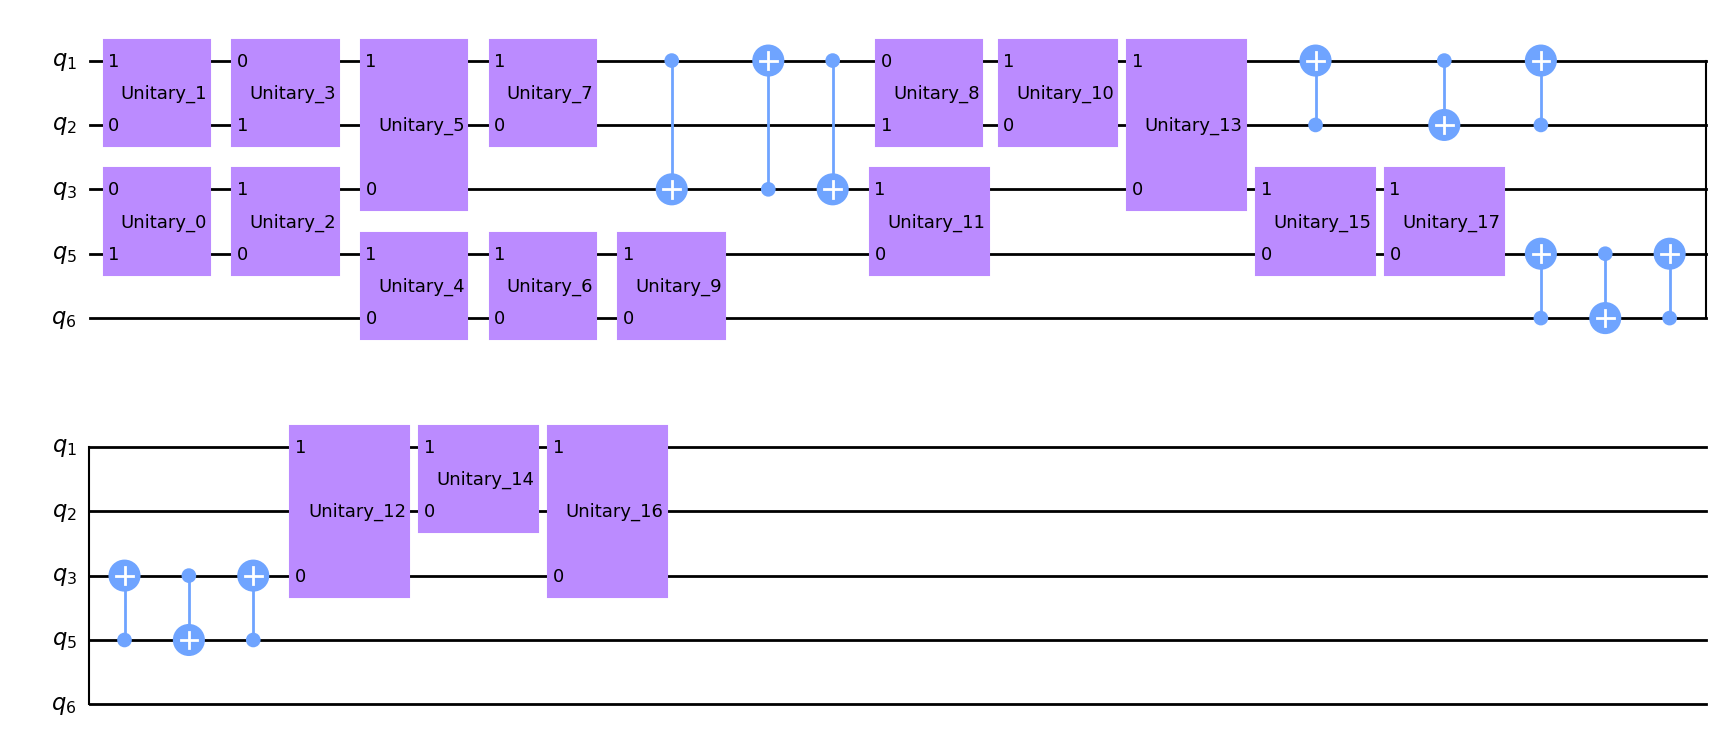

In [6]:
qc_tr_45.decompose(["swap"]).draw(output='mpl', idle_wires=False)

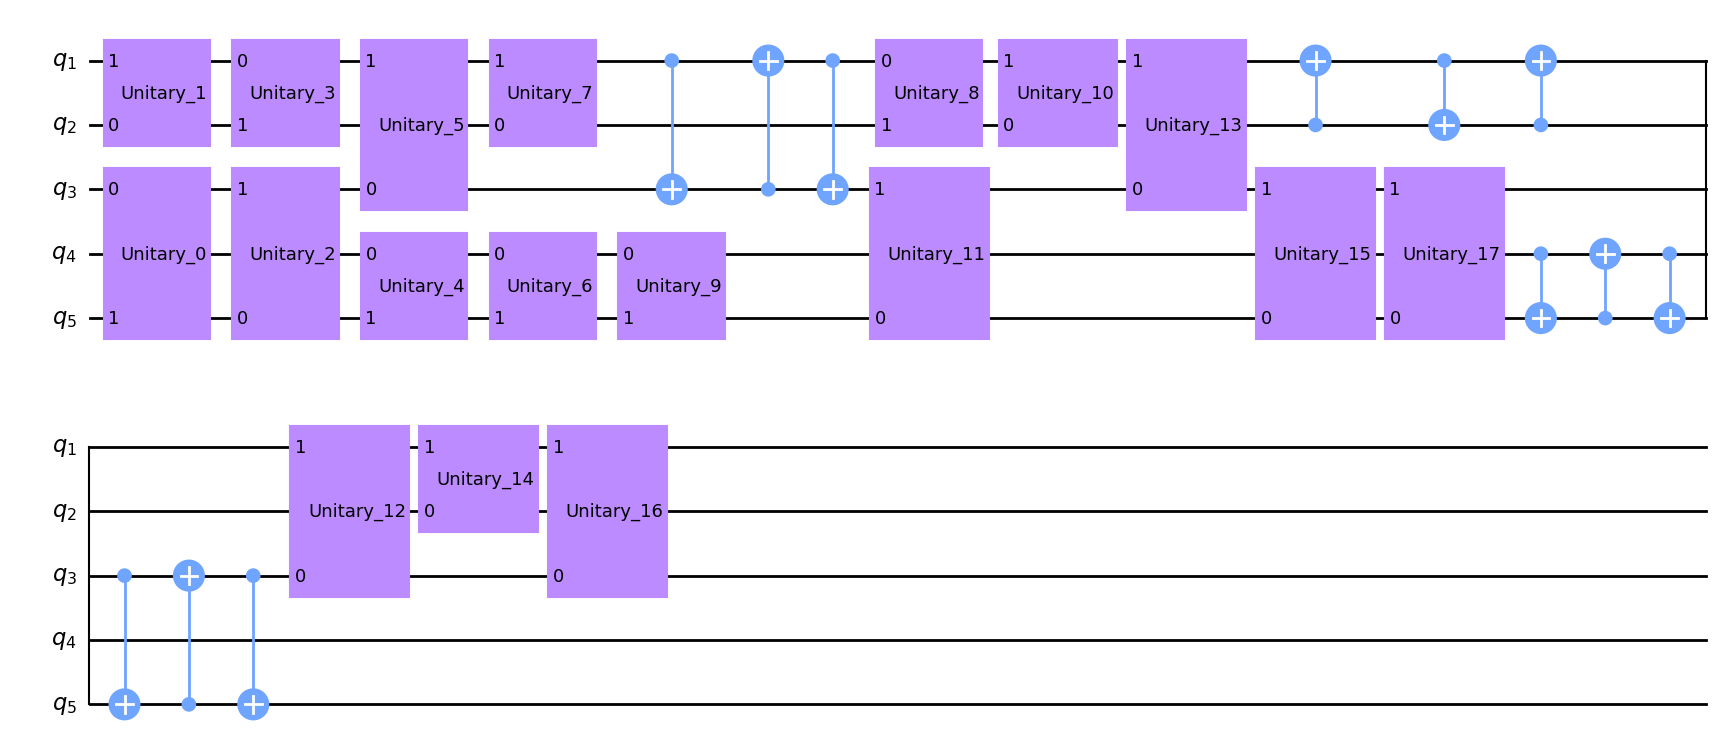

In [7]:
qc_tr_20.decompose(["swap"]).draw(output='mpl', idle_wires=False)

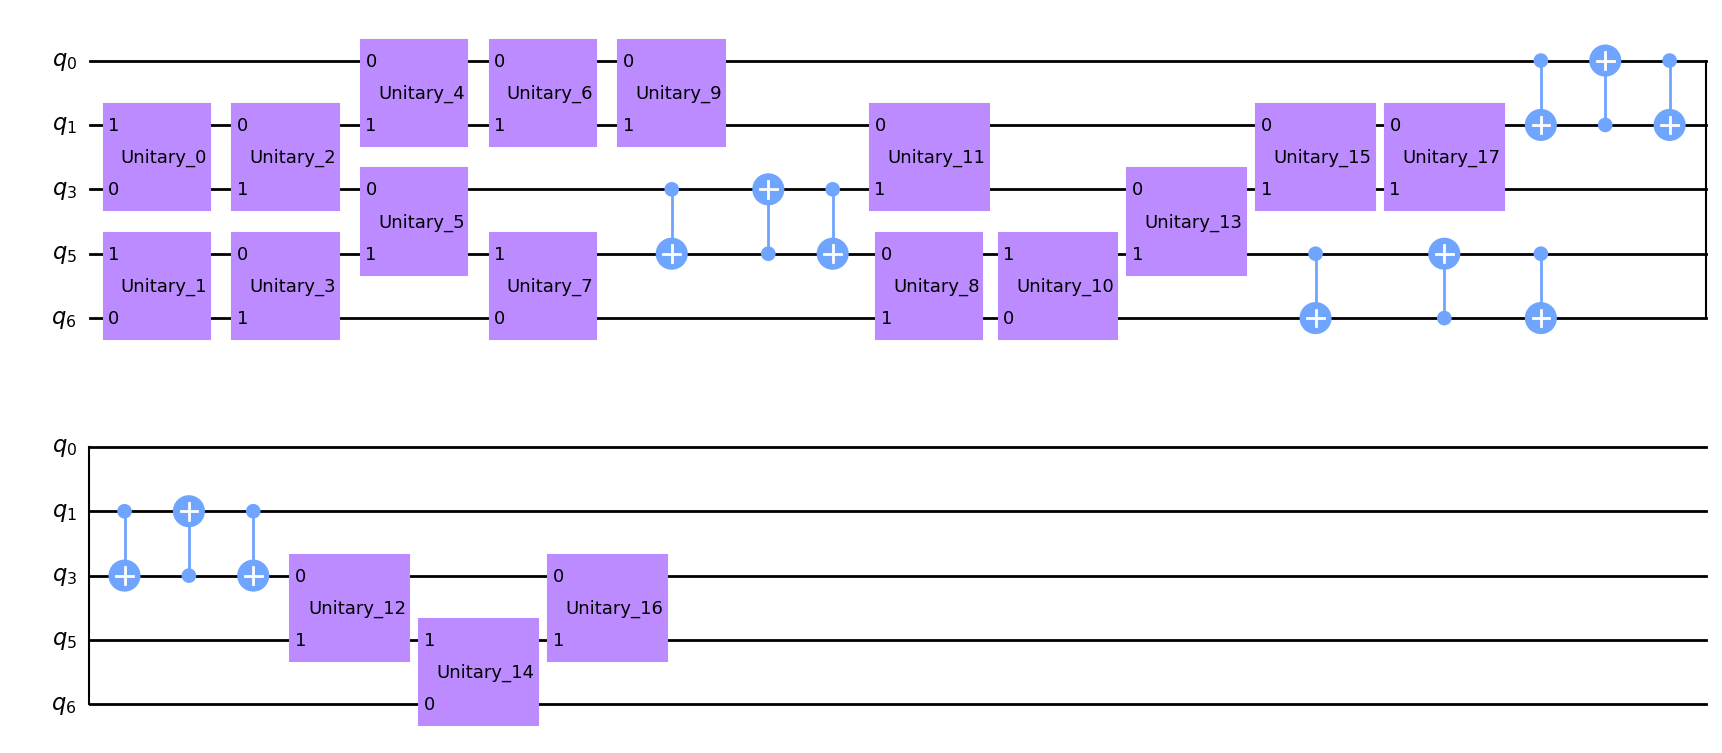

In [8]:
qc_tr_20_lookahead.decompose(["swap"]).draw(output='mpl', idle_wires=False)